In [1]:
import numpy as np
import torch
import torchvision

from models.i3d.i3d_src.i3d_net import I3D
from models.raft.extract_raft import DATASET_to_RAFT_CKPT_PATHS
from models.raft.raft_src.raft import RAFT, InputPadder

from models.transforms import (Clamp, PermuteAndUnsqueeze, PILToTensor,
                               ResizeImproved, ScaleTo1_1, TensorCenterCrop,
                               ToFloat, ToUInt8)

from utils.utils import dp_state_to_normal

import cv2



In [2]:
class CustomModel(torch.nn.Module):
    def __init__(self, I3D_weight_path, RAFT_weight_path, img_stack_size, device='cuda'):
        super().__init__()

        self.device = device
        self.padder = None
        self.stack_size = img_stack_size

        # self.i3d_model_rgb = I3D(num_classes=400, modality='rgb')
        # self.i3d_model_rgb.load_state_dict(torch.load(I3D_weight_path['rgb'], map_location='cpu'))
        # self.i3d_model_rgb = self.i3d_model_rgb.to(self.device).eval()

        # self.i3d_model_flow = I3D(num_classes=400, modality='flow')
        # self.i3d_model_flow.load_state_dict(torch.load(I3D_weight_path['flow'], map_location='cpu'))
        # self.i3d_model_flow = self.i3d_model_flow.to(self.device).eval()

        self.raft_model = RAFT()
        state_dict = dp_state_to_normal(torch.load(RAFT_weight_path, map_location='cpu'))
        self.raft_model.load_state_dict(state_dict)
        self.raft_model = self.raft_model.to(self.device).eval()

    def forward(self, x):
        rgb_stack = torch.cat(x).to(self.device)
        stream_slice = self.raft_model(self.padder.pad(rgb_stack)[:-1], self.padder.pad(rgb_stack)[1:])

        return stream_slice


In [3]:
video_path = "./videos/normal.mp4"

cap = cv2.VideoCapture(video_path)

I3D_weight_path = {"rgb" : "./models/i3d/checkpoints/i3d_rgb.pt",
                    "flow" : "./models/i3d/checkpoints/i3d_flow.pt"}

RAFT_weight_path = "./models/raft/checkpoints/raft-sintel.pth"

min_side_size = 256

resize_transforms = torchvision.transforms.Compose([torchvision.transforms.ToPILImage(),
                                                    ResizeImproved(min_side_size),
                                                    PILToTensor(),
                                                    ToFloat(),])

rgb_stack = []
stack_size = 60

model = CustomModel(I3D_weight_path, RAFT_weight_path, img_stack_size = stack_size, rgb_shape_size=(1280,720,3))

first_frame = True
while cap.isOpened():
    frame_exists, rgb = cap.read()

    if first_frame:
        first_frame = False
        if frame_exists is False:
            continue

    rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
    rgb = resize_transforms(rgb)
    rgb = rgb.unsqueeze(0)

    rgb_stack.append(rgb)

    if len(rgb_stack) - 1 == stack_size:
        result = model(rgb_stack)
        print(result.shape)

OutOfMemoryError: CUDA out of memory. Tried to allocate 864.00 MiB (GPU 0; 7.78 GiB total capacity; 5.63 GiB already allocated; 241.69 MiB free; 5.66 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [11]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

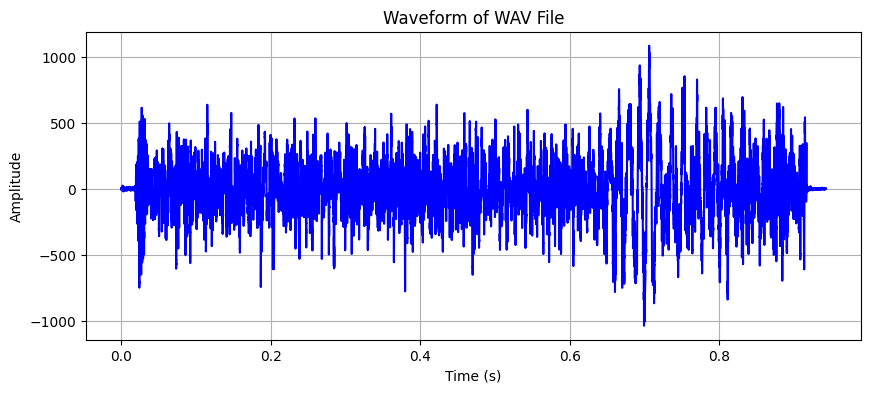

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import wave

# WAV 파일 경로 설정
wav_file = "./dataset/train/audios/test.wav"

# WAV 파일 열기
with wave.open(wav_file, "rb") as wav:
    # WAV 파일의 오디오 데이터 읽기
    frames = wav.readframes(-1)
    samples = np.frombuffer(frames, dtype="int16")

    # WAV 파일의 샘플 레이트와 채널 수 가져오기
    sample_rate = wav.getframerate()
    num_channels = wav.getnchannels()

# 오디오 데이터의 시간 배열 생성
duration = len(samples) / sample_rate
time = np.linspace(0., duration, len(samples))

# 그래프 그리기
plt.figure(figsize=(10, 4))
plt.plot(time, samples, color="b")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Waveform of WAV File")
plt.grid(True)
plt.show()

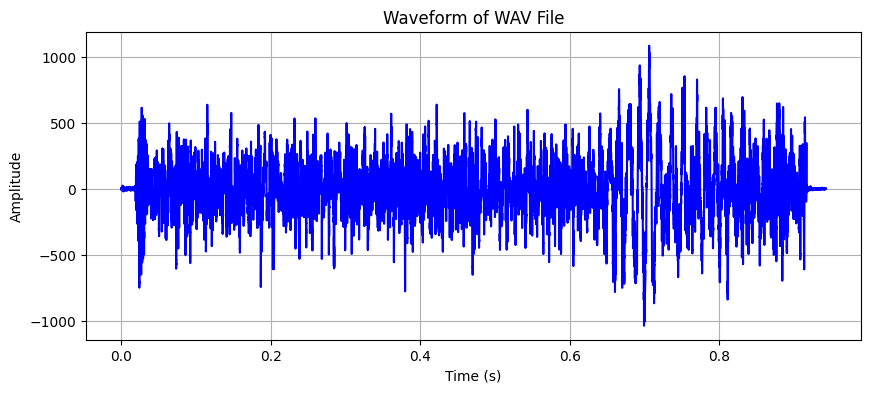

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import wave

# WAV 파일 경로 설정
wav_file = "./dataset/train/audios/normal_0.wav"

# WAV 파일 열기
with wave.open(wav_file, "rb") as wav:
    # WAV 파일의 오디오 데이터 읽기
    frames = wav.readframes(-1)
    samples = np.frombuffer(frames, dtype="int16")

    # WAV 파일의 샘플 레이트와 채널 수 가져오기
    sample_rate = wav.getframerate()
    num_channels = wav.getnchannels()

# 오디오 데이터의 시간 배열 생성
duration = len(samples) / sample_rate
time = np.linspace(0., duration, len(samples))

# 그래프 그리기
plt.figure(figsize=(10, 4))
plt.plot(time, samples, color="b")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Waveform of WAV File")
plt.grid(True)
plt.show()

In [1]:
from dataloader_custom import AC_Data_Loader
from torch.utils.data import TensorDataset, DataLoader
import torch
from custom_model import Img_Audio_Feature_Extraction, Action_Classification_Model
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('GPU Use : ',torch.cuda.is_available())

data_path_x = "./dataset/train/features/"
data_loader = AC_Data_Loader(data_path_x)

train_loader = DataLoader(dataset = data_loader, batch_size=1, shuffle=True)

model = Action_Classification_Model(device).to(device).eval()


GPU Use :  True


In [2]:
for i, (x_data, y_data) in enumerate(train_loader):
    print(i)
    print(x_data[0].shape)
    print(x_data[1].shape)
    print(x_data[2].shape)

    print(y_data)

    output = model(x_data)

    print(output)

0
torch.Size([1, 1024])
torch.Size([1, 1024])
torch.Size([1, 128])
tensor([[0, 1]])
tensor([[0.4971, 0.5029]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
torch.Size([1, 1024])
torch.Size([1, 1024])
torch.Size([1, 128])
tensor([[1, 0]])
tensor([[0.5162, 0.4838]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
2
torch.Size([1, 1024])
torch.Size([1, 1024])
torch.Size([1, 128])
tensor([[1, 0]])
tensor([[0.5030, 0.4970]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
3
torch.Size([1, 1024])
torch.Size([1, 1024])
torch.Size([1, 128])
tensor([[0, 1]])
tensor([[0.5030, 0.4970]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
4
torch.Size([1, 1024])
torch.Size([1, 1024])
torch.Size([1, 128])
tensor([[1, 0]])
tensor([[0.4971, 0.5029]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
5
torch.Size([1, 1024])
torch.Size([1, 1024])
torch.Size([1, 128])
tensor([[0, 1]])
tensor([[0.5162, 0.4838]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
6
torch.Size([1, 1024])
torch.Size([1, 1024])
torch.Size([1, 128

/home/drcl-yang/.local/lib/python3.8/site-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [25]:
data_loader.label_data[0]

1

In [26]:
model(torch.unsqueeze(data_loader[0][0], dim = 0))

tensor([[0.4947, 0.5053]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [27]:
(data_loader[0][0]).size()

torch.Size([2176])

In [28]:
torch.unsqueeze(data_loader[0][0], dim = 0).size()

torch.Size([1, 2176])

In [31]:
torch.mean(abs(data_loader[0][0]) - abs(data_loader[0][1]))

tensor(-0.8170, device='cuda:0')

In [17]:
import cv2 
import csv
from glob import glob
import numpy as np
import os
import random
import pandas as pd


HEIGHT=720
WIDTH=1280


dataset_path = 'dataset/train/images'
folder_list = os.listdir("./" + dataset_path)

p = os.path.join('./',dataset_path, folder_list[1], '00000000.png')
print(p)
a = cv2.imread(p)
h_ratio = a.shape[0] / HEIGHT
w_ratio = a.shape[1] / WIDTH


train_x = []
train_y = []
for folder_name in folder_list:
    all_path = glob(os.path.join(dataset_path, folder_name, '*'))
    train_path = all_path[:int(len(all_path)*1)]

    print(all_path)
    print(train_path)

    for i in range(len(train_path)):
        train_path[i] = train_path[i][len(os.path.join(dataset_path, folder_name)) + 1:]

    for p in train_path:
        #p = "1"
        #print(p)
        labelPath = os.path.join(dataset_path, 'csv', folder_name, '.csv')
        data = pd.read_csv(labelPath)
        no = data['Frame'].values
        v = data['Visibility'].values
        x = data['X'].values
        y = data['Y'].values
        radius = data['R'].values
    
    



./dataset/train/images/normal/00000000.png
[]
[]
[]
['dataset/train/images/normal/00007198.png', 'dataset/train/images/normal/00012085.png', 'dataset/train/images/normal/00002321.png', 'dataset/train/images/normal/00008989.png', 'dataset/train/images/normal/00011184.png', 'dataset/train/images/normal/00010571.png', 'dataset/train/images/normal/00005180.png', 'dataset/train/images/normal/00001363.png', 'dataset/train/images/normal/00002349.png', 'dataset/train/images/normal/00010792.png', 'dataset/train/images/normal/00008535.png', 'dataset/train/images/normal/00008319.png', 'dataset/train/images/normal/00003880.png', 'dataset/train/images/normal/00004819.png', 'dataset/train/images/normal/00009400.png', 'dataset/train/images/normal/00004550.png', 'dataset/train/images/normal/00012291.png', 'dataset/train/images/normal/00011904.png', 'dataset/train/images/normal/00012011.png', 'dataset/train/images/normal/00007964.png', 'dataset/train/images/normal/00006652.png', 'dataset/train/images/n

In [22]:
from dataloader_custom import AC_Data_Loader
from torch.utils.data import TensorDataset, DataLoader
import torch
from custom_model import Img_Audio_Feature_Extraction, Action_Classification_Model
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('GPU Use : ',torch.cuda.is_available())

data_path_x_normal = "./dataset/train/features/normal/"
data_path_x_abnormal = "./dataset/train/features/abnormal/"


PATH = "./models/custom/e100_Adadelta_0.02308845.pt"

data_loader = AC_Data_Loader(data_path_x_normal, data_path_x_abnormal)

train_loader = DataLoader(dataset = data_loader, batch_size=1, shuffle=True)

model = Action_Classification_Model(device)
model.load_state_dict(torch.load(PATH))
model.to(device).eval()

with torch.no_grad():
    for data, label in data_loader:
        data = data
    
        # y_pred = model(torch.unsqueeze(data, dim = 0))
        y_pred = model([torch.unsqueeze(data[0], dim = 0), torch.unsqueeze(data[1], dim = 0), torch.unsqueeze(data[2], dim = 0)])

        print(label , y_pred)


GPU Use :  True
tensor([0]) tensor([[5.7605e-06]], device='cuda:0')
tensor([0]) tensor([[1.8877e-06]], device='cuda:0')
tensor([0]) tensor([[8.4580e-06]], device='cuda:0')
tensor([0]) tensor([[7.4921e-07]], device='cuda:0')
tensor([0]) tensor([[7.1737e-06]], device='cuda:0')
tensor([0]) tensor([[1.4559e-05]], device='cuda:0')
tensor([0]) tensor([[1.1721e-05]], device='cuda:0')
tensor([0]) tensor([[0.0004]], device='cuda:0')
tensor([0]) tensor([[1.3765e-05]], device='cuda:0')
tensor([0]) tensor([[0.0005]], device='cuda:0')
tensor([0]) tensor([[1.6288e-06]], device='cuda:0')
tensor([0]) tensor([[4.0683e-06]], device='cuda:0')
tensor([0]) tensor([[9.1612e-08]], device='cuda:0')
tensor([0]) tensor([[3.5265e-06]], device='cuda:0')
tensor([0]) tensor([[1.1081e-05]], device='cuda:0')
tensor([0]) tensor([[2.9901e-06]], device='cuda:0')
tensor([0]) tensor([[5.2900e-06]], device='cuda:0')
tensor([0]) tensor([[2.3878e-05]], device='cuda:0')
tensor([0]) tensor([[1.1486e-05]], device='cuda:0')
tens